# NVIDIA NIMs 

> [NVIDIA NIMs](https://ai.nvidia.com) give users easy access to NVIDIA hosted API endpoints for AI models like Mixtral 8x22B, Llama 3, Stable Diffusion, etc. These models, hosted on the [https://build.nvidia.com](https://build.nvidia.com), are optimized, tested, and hosted on the NVIDIA AI platform, making them fast and easy to evaluate, further customize, and seamlessly run at peak performance on any accelerated stack.
> 
> With [NVIDIA NIMs](https://ai.nvidia.com), you can get quick results from a fully accelerated stack running on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/). These models can be deployed anywhere with enterprise-grade security, stability, and support using [NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/).
> 
> These models can be easily accessed via the [`llama-index-embeddings-nvidia`](https://pypi.org/project/llama-index-embeddings-nvidia/) package, as shown below.

This example goes over how to use LlamaIndex to interact with the supported [NVIDIA Retrieval QA Embedding Model](https://build.nvidia.com/explore/retrieval) for [retrieval-augmented generation](https://developer.nvidia.com/blog/build-enterprise-retrieval-augmented-generation-apps-with-nvidia-retrieval-qa-embedding-model/) via the `NVIDIAEmbedding` class.

## Installation

In [ ]:
%pip install --upgrade --quiet llama-index-embeddings-nvidia

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.

## Setup

**To get started:**

1. Create a free account with the [NVIDIA AI](https://build.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.

2. Navigate to any model and click `Get API Key`.

3. Save the generated key in your environment as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [ ]:
import getpass
import os

# del os.environ['NVIDIA_API_KEY']  ## delete key and reset
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    api_key = getpass.getpass("NVIDIA API Key (starts with nvapi-): ")
    assert api_key.startswith("nvapi-"), f"{api_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = api_key

## Initialization

When initializing an embedding model you can select a model by passing it, e.g. `NV-Embed-QA` below, or use the default by not passing any arguments.

In [ ]:
from llama_index.embeddings.nvidia import NVIDIAEmbedding

embedder = NVIDIAEmbedding(model="NV-Embed-QA")

This model is a fine-tuned E5-large model which supports the expected [`Embeddings`](https://docs.llamaindex.ai/en/stable/api_reference/embeddings/) methods including:

- `get_query_embedding`: Generate query embedding for a query sample.

- `get_text_embedding_batch`: Generate text embeddings for a list of documents which you would like to search over.

- And asynchronous versions of the above.

### **Similarity**

The following is a quick test of the similarity for these data points:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Texts:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

### Embedding queries

In [ ]:
print("\nSequential Embedding: ")
q_embeddings = [
    embedder.get_query_embedding("What's the weather like in Komchatka?"),
    embedder.get_query_embedding("What kinds of food is Italy known for?"),
    embedder.get_query_embedding(
        "What's my name? I bet you don't remember..."
    ),
    embedder.get_query_embedding("What's the point of life anyways?"),
    embedder.get_query_embedding("The point of life is to have fun :D"),
]
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Sequential Embedding: 
Shape: (5, 1024)


### Document Embedding

In [ ]:
print("\nBatch Document Embedding: ")
d_embeddings = embedder.get_text_embedding_batch(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
print("Shape:", (len(d_embeddings), len(d_embeddings[0])))


Batch Document Embedding: 
Shape: (5, 1024)


Now that we've generated our embeddings, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task:

In [ ]:
%pip install --upgrade --quiet matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


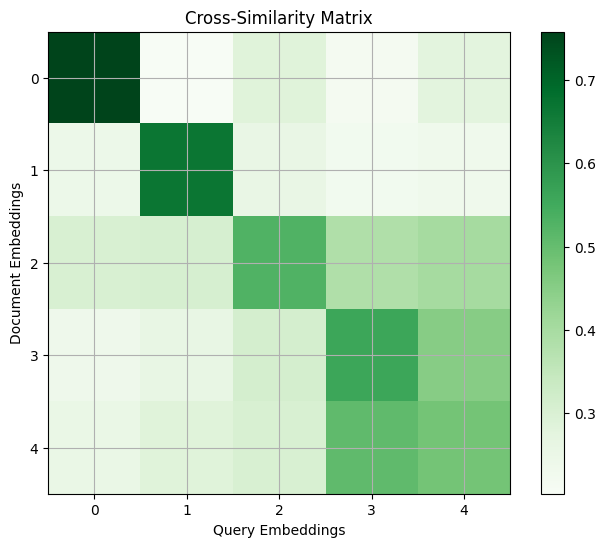

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix between q_embeddings and d_embeddings
cross_similarity_matrix = cosine_similarity(
    np.array(q_embeddings),
    np.array(d_embeddings),
)

# Plotting the cross-similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")
plt.colorbar()
plt.title("Cross-Similarity Matrix")
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.grid(True)
plt.show()

As a reminder, the queries and documents sent to our system were:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Texts:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

## Truncation

Embedding models typically have a fixed context window that determines the maximum number of input tokens that can be embedded. This limit could be a hard limit, equal to the model's maximum input token length, or an effective limit, beyond which the accuracy of the embedding decreases.

Since models operate on tokens and applications usually work with text, it can be challenging for an application to ensure that its input stays within the model's token limits. By default, an exception is thrown if the input is too large.

To assist with this, NVIDIA NIMs provide a `truncate` parameter that truncates the input on the server side if it's too large.

The `truncate` parameter has three options:
 - "NONE": The default option. An exception is thrown if the input is too large.
 - "START": The server truncates the input from the start (left), discarding tokens as necessary.
 - "END": The server truncates the input from the end (right), discarding tokens as necessary.

In [ ]:
long_text = "AI is amazing, amazing is " * 100

In [ ]:
strict_embedder = NVIDIAEmbedding()
try:
    strict_embedder.get_query_embedding(long_text)
except Exception as e:
    print("Error:", e)

Error: Error code: 400 - {'type': 'urn:nvcf-worker-service:problem-details:bad-request', 'title': 'Bad Request', 'status': 400, 'detail': 'Inference error', 'instance': '/v2/nvcf/pexec/functions/09c64e32-2b65-4892-a285-2f585408d118', 'requestId': 'ccaac47c-a61e-4eba-abe8-dc7f254f52b2'}


In [ ]:
truncating_embedder = NVIDIAEmbedding(truncate="END")
truncating_embedder.get_query_embedding(long_text)[:5]

[-0.008758544921875,
 0.0009446144104003906,
 -0.035064697265625,
 0.0254058837890625,
 0.00414276123046875]

## Connecting to local NIMs

In addition to connecting to hosted [NVIDIA NIMs](https://ai.nvidia.com), this connector can be used to connect to local microservice instances. This helps you take your applications local when necessary.

For instructions on how to setup local microservice instances, see https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/

In [ ]:
from llama_index.embeddings.nvidia import NVIDIAEmbedding

llm = NVIDIAEmbedding().mode("nim", base_url="http://0.0.0.0:12345/v1")
llm.available_models

[Model(id='e5-small-v2')]